In [ ]:
!pip install transformers datasets peft

In [ ]:
from datasets import load_dataset

# Load the dataset
dataset = load_dataset("facebook/empathetic_dialogues")

# Function to clean the data
def preprocess(example):
    # Replace "_comma_" with ", " in the utterance column
    if example["utterance"] is not None:  # Check for null values
        example["utterance"] = example["utterance"].replace("_comma_", ",")
    return example

# Apply preprocessing
dataset = dataset.map(preprocess)

# Function to remove null values
def remove_null(example):
    return example["utterance"] is not None  # Keep only non-null utterances

# Apply filtering to remove null values
dataset = dataset.filter(remove_null)

# Display an example after preprocessing
print(dataset["train"][0])


{'conv_id': 'hit:0_conv:1', 'utterance_idx': 1, 'context': 'sentimental', 'prompt': 'I remember going to the fireworks with my best friend. There was a lot of people_comma_ but it only felt like us in the world.', 'speaker_idx': 1, 'utterance': 'I remember going to see the fireworks with my best friend. It was the first time we ever spent time alone together. Although there was a lot of people, we felt like the only people in the world.', 'selfeval': '5|5|5_2|2|5', 'tags': ''}


In [ ]:
from transformers import AutoTokenizer, DataCollatorWithPadding

# Load DistilBERT tokenizer
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

# Data collator for dynamic padding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)


In [ ]:
import torch
from transformers import DataCollatorWithPadding
from torch.utils.data import DataLoader

# Create a mapping of unique emotion labels to integer values
emotion_labels = {label: idx for idx, label in enumerate(set(dataset["train"]["context"]))}

def encode_labels(example):
    example["labels"] = emotion_labels[example["context"]]  # Convert emotion to integer
    return example

# Apply the label encoding function
dataset = dataset.map(encode_labels)


tokenized_datasets = dataset.map(
    lambda x: tokenizer(
        x["utterance"],  # Ensure this is the correct text column
        padding=True,
        truncation=True,
        max_length=32
    ),
    batched=True
)

#data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
# Create DataLoader
#train_dataloader = DataLoader(tokenized_datasets["train"], batch_size=16, shuffle=True, collate_fn=data_collator)
train_dataloader = DataLoader(
    tokenized_datasets["train"],
    batch_size=16,
    shuffle=True,
    collate_fn=data_collator  # Dynamic padding applied here
)

Map:   0%|          | 0/76673 [00:00<?, ? examples/s]

Map:   0%|          | 0/12030 [00:00<?, ? examples/s]

Map:   0%|          | 0/10943 [00:00<?, ? examples/s]

Map:   0%|          | 0/76673 [00:00<?, ? examples/s]

Map:   0%|          | 0/12030 [00:00<?, ? examples/s]

Map:   0%|          | 0/10943 [00:00<?, ? examples/s]

In [ ]:
print(tokenized_datasets["train"][0:65])

{'conv_id': ['hit:0_conv:1', 'hit:0_conv:1', 'hit:0_conv:1', 'hit:0_conv:1', 'hit:0_conv:1', 'hit:0_conv:1', 'hit:1_conv:2', 'hit:1_conv:2', 'hit:1_conv:2', 'hit:1_conv:2', 'hit:1_conv:2', 'hit:1_conv:2', 'hit:1_conv:3', 'hit:1_conv:3', 'hit:1_conv:3', 'hit:1_conv:3', 'hit:1_conv:3', 'hit:2_conv:4', 'hit:2_conv:4', 'hit:2_conv:4', 'hit:2_conv:4', 'hit:2_conv:5', 'hit:2_conv:5', 'hit:2_conv:5', 'hit:2_conv:5', 'hit:2_conv:5', 'hit:3_conv:7', 'hit:3_conv:7', 'hit:3_conv:7', 'hit:3_conv:7', 'hit:4_conv:8', 'hit:4_conv:8', 'hit:4_conv:8', 'hit:4_conv:8', 'hit:5_conv:10', 'hit:5_conv:10', 'hit:5_conv:10', 'hit:5_conv:10', 'hit:5_conv:10', 'hit:5_conv:11', 'hit:5_conv:11', 'hit:5_conv:11', 'hit:5_conv:11', 'hit:6_conv:13', 'hit:7_conv:14', 'hit:7_conv:14', 'hit:7_conv:14', 'hit:7_conv:14', 'hit:7_conv:15', 'hit:7_conv:15', 'hit:7_conv:15', 'hit:7_conv:15', 'hit:7_conv:15', 'hit:8_conv:16', 'hit:8_conv:16', 'hit:8_conv:16', 'hit:8_conv:16', 'hit:9_conv:19', 'hit:9_conv:19', 'hit:9_conv:19', '

In [ ]:
tokenized_datasets.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
print(tokenized_datasets["train"][0])


{'labels': tensor(8), 'input_ids': tensor([  101,  1045,  3342,  2183,  2000,  2156,  1996, 16080,  2007,  2026,
         2190,  2767,  1012,  2009,  2001,  1996,  2034,  2051,  2057,  2412,
         2985,  2051,  2894,  2362,  1012,  2348,  2045,  2001,  1037,  2843,
         1997,   102]), 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1])}


In [ ]:
from transformers import AutoModelForSequenceClassification
from peft import get_peft_model, LoraConfig, TaskType

# Load the pre-trained model
model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased", num_labels=len(emotion_labels)
)


from peft import LoraConfig, get_peft_model

lora_config = LoraConfig(
    r=8,  # Rank of LoRA matrices
    lora_alpha=32,  # Scaling factor
    lora_dropout=0.1,  # Dropout for LoRA layers
    target_modules=["q_lin", "v_lin"],  # LoRA applied to attention layers
    task_type="SEQ_CLS"  # Task type: Sequence Classification
)

# Apply LoRA to the model
model = get_peft_model(model, lora_config)


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
import torch

optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)

# Training
model.train()
for epoch in range(1):  # Number of epochs
    total_loss = 0  # Track total loss
    for batch_idx, batch in enumerate(train_dataloader):
        optimizer.zero_grad()
        inputs = {k: v for k, v in batch.items() if k in ["input_ids", "attention_mask"]}
        labels = batch["labels"]
        outputs = model(**inputs, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

        # Track loss
        total_loss += loss.item()

        # Print progress every 10 batches
        if batch_idx % 100 == 0:
            print(f"Epoch {epoch+1}, Batch {batch_idx}, Loss: {loss.item():.4f}")

    # Print average loss per epoch
    print(f"Epoch {epoch+1} completed. Average Loss: {total_loss / len(train_dataloader):.4f}")


Epoch 1, Batch 0, Loss: 3.4834
Epoch 1, Batch 100, Loss: 3.0085
Epoch 1, Batch 200, Loss: 2.9084
Epoch 1, Batch 300, Loss: 2.4356
Epoch 1, Batch 400, Loss: 2.7124
Epoch 1, Batch 500, Loss: 2.8716
Epoch 1, Batch 600, Loss: 3.0051
Epoch 1, Batch 700, Loss: 2.9913
Epoch 1, Batch 800, Loss: 3.4430
Epoch 1, Batch 900, Loss: 2.7933
Epoch 1, Batch 1000, Loss: 2.9256
Epoch 1, Batch 1100, Loss: 3.1546
Epoch 1, Batch 1200, Loss: 2.6420
Epoch 1, Batch 1300, Loss: 3.4107
Epoch 1, Batch 1400, Loss: 3.0852
Epoch 1, Batch 1500, Loss: 2.7274
Epoch 1, Batch 1600, Loss: 2.7848
Epoch 1, Batch 1700, Loss: 2.4840
Epoch 1, Batch 1800, Loss: 2.8564
Epoch 1, Batch 1900, Loss: 2.6730
Epoch 1, Batch 2000, Loss: 2.9275
Epoch 1, Batch 2100, Loss: 2.4675
Epoch 1, Batch 2200, Loss: 2.8046
Epoch 1, Batch 2300, Loss: 2.6047
Epoch 1, Batch 2400, Loss: 2.8832
Epoch 1, Batch 2500, Loss: 2.9865
Epoch 1, Batch 2600, Loss: 2.7621
Epoch 1, Batch 2700, Loss: 2.7382
Epoch 1, Batch 2800, Loss: 3.2941
Epoch 1, Batch 2900, Loss:

In [ ]:
# Create validation DataLoader
valid_dataloader = DataLoader(
    tokenized_datasets["validation"],  # Use the validation dataset
    batch_size=16,  # Same batch size as training
    shuffle=False,  # No need to shuffle validation data
    collate_fn=data_collator  # Use the same padding strategy
)


In [ ]:
print(dataset["validation"][0])

{'conv_id': 'hit:3_conv:6', 'utterance_idx': 1, 'context': 'terrified', 'prompt': 'Today_comma_as i was leaving for work in the morning_comma_i had a tire burst in the middle of a busy road. That scared the hell out of me!', 'speaker_idx': 6, 'utterance': 'Today,as i was leaving for work in the morning,i had a tire burst in the middle of a busy road. That scared the hell out of me!', 'selfeval': '4|5|5_5|5|5', 'tags': '', 'labels': 18}


In [ ]:
!pip install scikit-learn


In [ ]:
import torch
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Switch to evaluation mode
model.eval()

# Track loss and predictions
total_loss = 0
all_predictions = []
all_labels = []

# No gradient calculation (faster inference)
with torch.no_grad():
    for batch in valid_dataloader:
        inputs = {k: v for k, v in batch.items() if k in ["input_ids", "attention_mask"]}
        labels = batch["labels"]

        outputs = model(**inputs, labels=labels)
        loss = outputs.loss
        logits = outputs.logits  # Model's raw predictions

        # Store total loss
        total_loss += loss.item()

        # Get predicted labels (highest probability class)
        predictions = torch.argmax(logits, dim=-1)

        # Store labels and predictions
        all_predictions.extend(predictions.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Convert to NumPy arrays
all_predictions = torch.tensor(all_predictions)
all_labels = torch.tensor(all_labels)

# Calculate average validation loss
avg_loss = total_loss / len(valid_dataloader)

# Compute evaluation metrics
accuracy = accuracy_score(all_labels, all_predictions)
precision = precision_score(all_labels, all_predictions, average="weighted")  # Weighted for class imbalance
recall = recall_score(all_labels, all_predictions, average="weighted")
f1 = f1_score(all_labels, all_predictions, average="weighted")
conf_matrix = confusion_matrix(all_labels, all_predictions)

# Display results
print(f"Validation Loss: {avg_loss:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")
print("Confusion Matrix:")
print(conf_matrix)


Validation Loss: 2.7985
Accuracy: 0.2295
Precision: 0.2393
Recall: 0.2295
F1-score: 0.2157
Confusion Matrix:
[[ 35   4  65 ...   2   2   7]
 [  1  29   7 ...   4   4   2]
 [  4   1 137 ...   2   2   1]
 ...
 [  2   1   6 ...  79   4   0]
 [  9   3  15 ...   4  33   0]
 [  6  13  41 ...   3   0  34]]


In [ ]:
!pip install seaborn


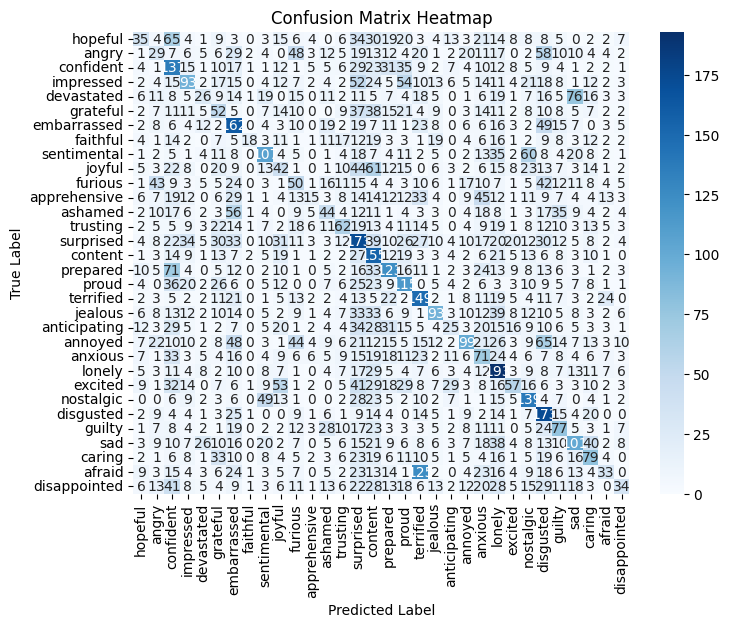

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Plot confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=emotion_labels, yticklabels=emotion_labels)

# Labels and title
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix Heatmap")
plt.show()
